In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd
from datasets import Dataset, DatasetDict

import json

In [2]:
with open('./party_lst.json') as json_file:
    parties = json.load(json_file)
parties

['Socialdemokratiet',
 'Venstre',
 'Socialistisk Folkeparti',
 'Det Radikale Venstre',
 'Enhedslisten',
 'Det Konservative Folkeparti',
 'Dansk Folkeparti',
 'Liberal Alliance',
 'Alternativet']

## Flow for each party

### One by one

In [4]:
party = "Alternativet"

In [5]:
df_train = pd.read_csv("./by_party_train/" + party + ".csv")
df_test = pd.read_csv("./by_party_test/" + party + ".csv")
df_train.head(2)

,Unnamed: 0,Absent,Against,For,Neutral,parties,description,date
0,9,1,0,0,0,Alternativet (ALT),"Regeringen (Socialdemokratiet), Radikale Venst...",2021-02-13
1,5,4,0,6,0,Alternativet (ALT),Forslaget har til formål at gennemføre en lang...,2018-05-15


In [ ]:
def preprocess_vote(df):
  
  df['label'] = df.apply(lambda x: 1 if x['Neutral']<x['Against']>x['For'] else 0 if x['Neutral']<x['For']>x['Against'] else None, axis=1)

  df.rename(columns={'description':'text'}, inplace=True)
  df = df[['text', 'label']]
  df = df.dropna()
  df['label'] = df.apply(lambda x: int(x['label']), axis=1)

  return df

## Note "Against" = 1

In [ ]:
df_train = preprocess_vote(df_train)
df_test = preprocess_vote(df_test)
df_train.head(2)

In [ ]:
train_set = Dataset.from_pandas(df_train, preserve_index=True)
test_set = Dataset.from_pandas(df_test, preserve_index=True)
dataset = DatasetDict({'train':train_set,
                        'test':test_set})
dataset

In [ ]:
#Models
klimaBERT = "/klimaBERTe4_v2.1"
checkpoint = klimaBERT

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], padding=True, truncation=True, max_length=512)
    return tokenized_batch

tokenized_datasets = dataset.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
## Steps for processing data
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

## Rename label column to labels, if not already done
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")
tokenized_datasets.column_names
## Our model needs columns that it already knows (the 4 below, NOT any custom columns like "text"):
#['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
from datasets import load_metric
from datasets import load_metric
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc_score': roc_auc
    }

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForSequenceClassification

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", per_device_train_batch_size=2, num_train_epochs=5, seed=2022, save_strategy="no")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) #Change num  of labels if needed

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
## Set to use GPU
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("models_binary_party/"+party)

##### Metrics

In [16]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier
m = torch.nn.Softmax(dim=-1)

In [17]:

weight_pred = trainer.predict(tokenized_datasets["test"])[0]
weight_for = []
weight_against = []
for input in weight_pred:
    input2 = torch.from_numpy(input)
    (i,k) = m(input2) #i=against, k=for
    weight_for.append(i.item())
    weight_against.append(k.item())

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1560
  Batch size = 8
100%|██████████| 195/195 [02:16<00:00,  1.41it/s]c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


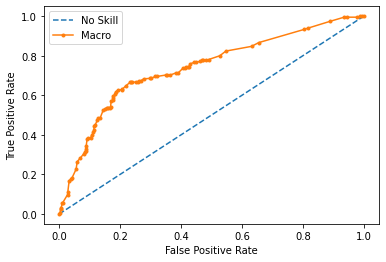

No Skill ROC AUC 0.508
Baseline ROC AUC 0.739


In [19]:
## ROC CURVE
testy = tokenized_datasets["test"]["labels"]

# plot no skill roc curve
model = DummyClassifier(strategy='stratified')
model.fit(tokenized_datasets["train"], tokenized_datasets["train"]["labels"])
yhat = model.predict_proba(tokenized_datasets["test"])
pos_probs = yhat[:, 1]
roc_auc_noskill = roc_auc_score(testy, pos_probs)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# plot the skill curve
# retrieve just the probabilities for the positive class
pos_probs = weight_against
# calculate roc curve for model
fpr, tpr, _ = roc_curve(testy, pos_probs)

# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label=f'Macro')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()


roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc_noskill)
print('Baseline ROC AUC %.3f' % roc_auc)

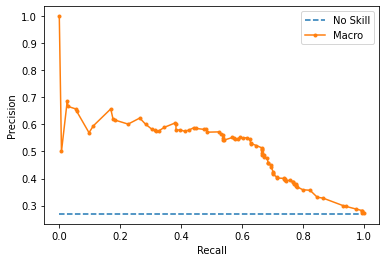

No Skill PR AUC: 0.369
Logistic PR AUC: 0.511


In [20]:
## PR Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
y = tokenized_datasets["test"]
no_of_pos = y["labels"].sum().item()


# calculate the no skill line as the proportion of the positive class
no_skill = (no_of_pos / len(y))
# plot the no skill precision-recall curve
model = DummyClassifier(strategy='stratified')
model.fit(tokenized_datasets["train"], tokenized_datasets["train"]["labels"])
yhat = model.predict_proba(tokenized_datasets["test"])
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score_noskill = auc(recall, precision)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
pos_probs = weight_against
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label=f'Macro')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score_noskill)
print('Logistic PR AUC: %.3f' % auc_score)

### Loop for all parties

In [ ]:
for party in parties:
    df_train = pd.read_csv("./by_party_train" + party + ".csv")
    df_test = pd.read_csv("./by_party_test" + party + ".csv")


## For all (macro)

In [3]:
df = pd.read_pickle("../../climate_classifier/scored_data/votes_data_all_expanded_politician.pkl")
df = df.sample(frac=0.3)
print(len(df))
df_c = df[df["y_pred"]=="climate"]
print(len(df_c))
df_c["year"] = df_c["date"].astype("str").str[:4]
df_c = df_c[df_c["year"].astype("int")>=2012]
df_c.head(1)
print(len(df_c))



290893
20423
12978


C:\Users\COBOD\AppData\Local\Temp/ipykernel_12036/1141518180.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c["year"] = df_c["date"].astype("str").str[:4]


In [4]:
df_c[["For", "Absent", "Neutral", "Against"]] = pd.get_dummies(df_c["vote"])
df_c = df_c[["For", "Absent", "Neutral", "Against", "description", "date"]]
df_c.sort_values(by="date").head(2)

,For,Absent,Neutral,Against,description,date
10,1,0,0,0,De danske ressourcer af olie og gas skal udnyt...,2012-02-23
154,1,0,0,0,De danske ressourcer af olie og gas skal udnyt...,2012-02-23


In [5]:
print(len(df_c))
print(len(df_c)*0.8)
print(len(df_c)*0.2)

df_train = df_c[:10236]
df_test = df_c[10236:]
print(len(df_train))
print(len(df_test))

12978
10382.400000000001
2595.6000000000004
10236
2742


In [6]:
def preprocess_vote(df):
  
  df['label'] = df.apply(lambda x: 1 if x['Neutral']<x['Against']>x['For'] else 0 if x['Neutral']<x['For']>x['Against'] else None, axis=1)

  df.rename(columns={'description':'text'}, inplace=True)
  df = df[['text', 'label']]
  df = df.dropna()
  df['label'] = df.apply(lambda x: int(x['label']), axis=1)

  return df

## Note "Against" = 1

In [7]:
df_train = preprocess_vote(df_train)
df_test = preprocess_vote(df_test)
df_train.head(2)

C:\Users\COBOD\AppData\Local\Temp/ipykernel_12036/479257593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.apply(lambda x: 1 if x['Neutral']<x['Against']>x['For'] else 0 if x['Neutral']<x['For']>x['Against'] else None, axis=1)
c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,text,label
49,Beslutningsforslaget pålægger regeringen at la...,1
49,Folketinget opfordrer til fastholdelse af den ...,1


In [8]:
train_set = Dataset.from_pandas(df_train, preserve_index=True)
test_set = Dataset.from_pandas(df_test, preserve_index=True)
dataset = DatasetDict({'train':train_set,
                        'test':test_set})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 5802
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1560
    })
})

In [9]:
#Models
klimaBERT = "/klimaBERTe4_v2.1"
checkpoint = klimaBERT

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], padding=True, truncation=True, max_length=512)
    return tokenized_batch

tokenized_datasets = dataset.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

100%|██████████| 2/2 [00:00<00:00,  2.88ba/s]


In [11]:
## Steps for processing data
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

## Rename label column to labels, if not already done
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")
tokenized_datasets.column_names
## Our model needs columns that it already knows (the 4 below, NOT any custom columns like "text"):
#['labels', 'input_ids', 'token_type_ids', 'attention_mask']

{'train': ['labels',
  '__index_level_0__',
  'input_ids',
  'token_type_ids',
  'attention_mask'],
 'test': ['labels',
  '__index_level_0__',
  'input_ids',
  'token_type_ids',
  'attention_mask']}

In [12]:
from datasets import load_metric
from datasets import load_metric
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc_score': roc_auc
    }

In [13]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForSequenceClassification

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", per_device_train_batch_size=2, seed=2022, save_strategy="no")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) #Change num  of labels if needed

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [14]:
## Set to use GPU
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [15]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5802
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 8703
  6%|▌         | 500/8703 [05:30<1:29:39,  1.52it/s]

{'loss': 0.9693, 'learning_rate': 4.71274273239113e-05, 'epoch': 0.17}


 11%|█▏        | 1000/8703 [10:58<1:24:12,  1.52it/s]

{'loss': 0.788, 'learning_rate': 4.425485464782259e-05, 'epoch': 0.34}


 17%|█▋        | 1500/8703 [16:27<1:18:36,  1.53it/s]

{'loss': 0.7738, 'learning_rate': 4.138228197173389e-05, 'epoch': 0.52}


 23%|██▎       | 2000/8703 [21:55<1:13:02,  1.53it/s]

{'loss': 0.8012, 'learning_rate': 3.850970929564518e-05, 'epoch': 0.69}


 29%|██▊       | 2500/8703 [27:23<1:07:48,  1.52it/s]

{'loss': 0.7385, 'learning_rate': 3.563713661955648e-05, 'epoch': 0.86}


 33%|███▎      | 2901/8703 [31:47<1:03:28,  1.52it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1560
  Batch size = 8
                                                     
 33%|███▎      | 2901/8703 [34:06<1:03:28,  1.52it/s]

{'eval_loss': 0.7350964546203613, 'eval_accuracy': 0.8064102564102564, 'eval_f1': 0.616751269035533, 'eval_precision': 0.6603260869565217, 'eval_recall': 0.5785714285714286, 'eval_roc_auc_score': 0.7344611528822056, 'eval_runtime': 139.4191, 'eval_samples_per_second': 11.189, 'eval_steps_per_second': 1.399, 'epoch': 1.0}


 34%|███▍      | 3000/8703 [35:11<1:02:40,  1.52it/s] 

{'loss': 0.6996, 'learning_rate': 3.276456394346777e-05, 'epoch': 1.03}


 40%|████      | 3500/8703 [40:40<56:56,  1.52it/s]  

{'loss': 0.7091, 'learning_rate': 2.9891991267379065e-05, 'epoch': 1.21}


 46%|████▌     | 4000/8703 [46:08<51:24,  1.52it/s]

{'loss': 0.8469, 'learning_rate': 2.7019418591290363e-05, 'epoch': 1.38}


 52%|█████▏    | 4500/8703 [51:36<46:02,  1.52it/s]

{'loss': 0.9108, 'learning_rate': 2.4146845915201654e-05, 'epoch': 1.55}


 57%|█████▋    | 5000/8703 [57:05<40:25,  1.53it/s]

{'loss': 1.035, 'learning_rate': 2.1274273239112952e-05, 'epoch': 1.72}


 63%|██████▎   | 5500/8703 [1:02:33<35:01,  1.52it/s]

{'loss': 1.0554, 'learning_rate': 1.8401700563024247e-05, 'epoch': 1.9}


 67%|██████▋   | 5802/8703 [1:05:51<31:41,  1.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1560
  Batch size = 8
c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                     
 67%|██████▋   | 5802/8703 [1:08:11<31:41,  1.53it/s]

{'eval_loss': 1.0776957273483276, 'eval_accuracy': 0.7307692307692307, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_roc_auc_score': 0.5, 'eval_runtime': 139.2534, 'eval_samples_per_second': 11.203, 'eval_steps_per_second': 1.4, 'epoch': 2.0}


 69%|██████▉   | 6000/8703 [1:10:20<29:32,  1.52it/s]   

{'loss': 1.0386, 'learning_rate': 1.5529127886935542e-05, 'epoch': 2.07}


 75%|███████▍  | 6500/8703 [1:15:48<24:01,  1.53it/s]

{'loss': 0.8958, 'learning_rate': 1.2656555210846835e-05, 'epoch': 2.24}


 80%|████████  | 7000/8703 [1:21:16<18:34,  1.53it/s]

{'loss': 1.049, 'learning_rate': 9.78398253475813e-06, 'epoch': 2.41}


 86%|████████▌ | 7500/8703 [1:26:43<13:06,  1.53it/s]

{'loss': 1.0876, 'learning_rate': 6.911409858669425e-06, 'epoch': 2.59}


 92%|█████████▏| 8000/8703 [1:32:10<07:41,  1.52it/s]

{'loss': 1.0866, 'learning_rate': 4.03883718258072e-06, 'epoch': 2.76}


 98%|█████████▊| 8500/8703 [1:37:38<02:13,  1.52it/s]

{'loss': 0.9444, 'learning_rate': 1.1662645064920143e-06, 'epoch': 2.93}


100%|██████████| 8703/8703 [1:39:51<00:00,  1.53it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1560
  Batch size = 8
c:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                     
100%|██████████| 8703/8703 [1:42:10<00:00,  1.53it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 8703/8703 [1:42:10<00:00,  1.42it/s]

{'eval_loss': 1.0225214958190918, 'eval_accuracy': 0.7307692307692307, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_roc_auc_score': 0.5, 'eval_runtime': 138.9279, 'eval_samples_per_second': 11.229, 'eval_steps_per_second': 1.404, 'epoch': 3.0}
{'train_runtime': 6130.4114, 'train_samples_per_second': 2.839, 'train_steps_per_second': 1.42, 'train_loss': 0.91026301067834, 'epoch': 3.0}


TrainOutput(global_step=8703, training_loss=0.91026301067834, metrics={'train_runtime': 6130.4114, 'train_samples_per_second': 2.839, 'train_steps_per_second': 1.42, 'train_loss': 0.91026301067834, 'epoch': 3.0})